L'objectif de cette analyse est de créer un modéle en Machine Learning et de l'entrainer avec un modéle en Deep Learning pour l'élaboration d'un modéle en IA capable de prédire si un patient est atteint de pneumonie. 

L'objectif d'apprentisage Deep Learning est de reconnaitre une radiographie d'une cage thoracique. 
Plus la radio thoracique est clair moins il a de risque de présence de pneumonie et à l'inverse plus la radio présente des zones d'opacité est plus nous devons être en mesure de prédire une pneumonie. 

Pour notre modélisation nous allons labéliser notre y, qui correspond à la variable prédite en posant : 0 pour NORMAL et 1 pour PNEUMONIE


# 📚 Import des bibliothèques
___

In [141]:
import os 
import numpy as np
import pandas as pd 
import matplotlib as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

# 1.🔍 Exploration des données 
___

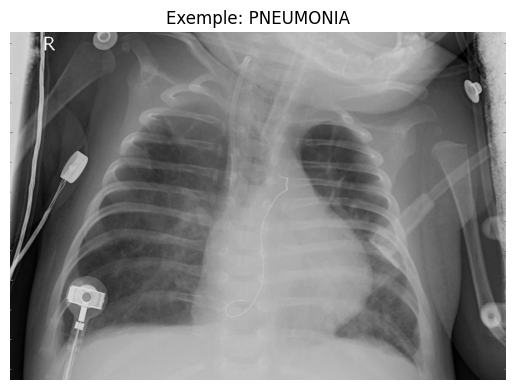

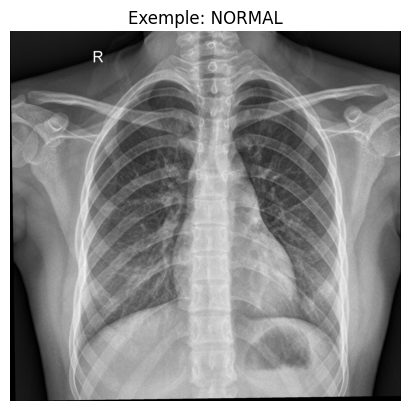


Total d'images dans 'data/chest_xray/train' : 5216

Total tailles d'images rencontrées : 4366


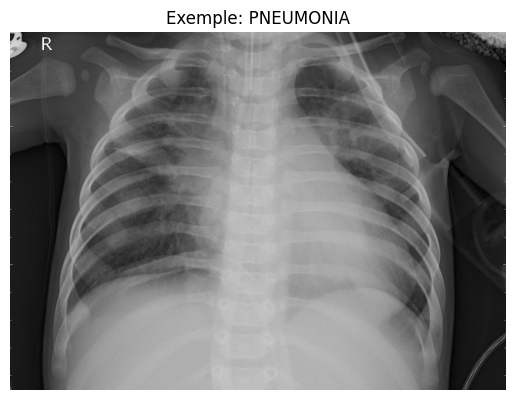

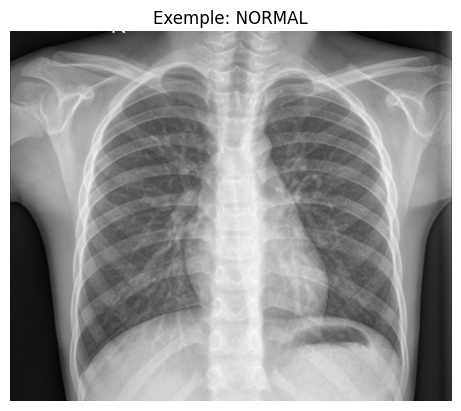


Total d'images dans 'data/chest_xray/test' : 624

Total tailles d'images rencontrées : 598


In [142]:
def explore_images(data_dir, img_read_type: int):
    
    unique_shapes = set()
    displayed = set()
    total_images = 0

    for label_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label_name)
        if not os.path.isdir(class_dir):
            continue

        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(class_dir, filename)
                img = cv2.imread(filepath, img_read_type)
                if img is None:
                    continue  # image illisible
                unique_shapes.add(img.shape)
                total_images += 1

                # Afficher la première image de chaque dossier
                if label_name not in displayed:
                    displayed.add(label_name)
                    plt.imshow(img if img_read_type == cv2.IMREAD_GRAYSCALE else cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    plt.title(f"Exemple: {label_name}")
                    plt.axis('off')
                    plt.show()

    print(f"\nTotal d'images dans '{data_dir}' : {total_images}")
    print(f"\nTotal tailles d'images rencontrées : {len(unique_shapes)}")


explore_images("data/chest_xray/train", cv2.IMREAD_COLOR)
explore_images("data/chest_xray/test", cv2.IMREAD_COLOR)

# 2.⏳ Chargement de la données 
___

In [181]:
def load_data(data_dir, img_read_type: int, target_size=(64, 64)):

    X = []
    y = []
    label_map = {'NORMAL': 0, 'PNEUMONIA': 1}

    for label_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(data_dir, label_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(class_dir, filename)
                img = cv2.imread(filepath, img_read_type)
                if img is None:
                    continue  # image illisible, on passe
                img = cv2.resize(img, target_size)
                X.append(img)
                y.append(label_map[label_name])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y


# Chargement des images en niveau de gris
X_train, y_train = load_data('data/chest_xray/train', cv2.IMREAD_GRAYSCALE)
X_test, y_test = load_data('data/chest_xray/test', cv2.IMREAD_GRAYSCALE)



In [145]:

def get_images_labels(base_path: str, label_value: int, target_size=(64, 64)):
    X = []
    y = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")

    for file_name in os.listdir(base_path):
        if not file_name.lower().endswith(valid_extensions):
            continue

        file_path = os.path.join(base_path, file_name)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Erreur de lecture image : {file_path}")
            continue

        # Redimensionner l'image
        img_resized = cv2.resize(img, target_size)

        # Vérifier la forme et le type
        if not isinstance(img_resized, np.ndarray):
            print(f"Image non convertie en ndarray: {file_path}")
            continue
        if img_resized.shape != target_size:
            print(f"Taille inattendue: {file_path}, shape: {img_resized.shape}")
            continue

        X.append(img_resized)
        y.append(label_value)

    print(f"Images chargées dans {base_path} : {len(X)}")
    return np.array(X), np.array(y)





# 3.🧹 Préparation des données
___

In [146]:
# Appel des train/ test 

X_train_NORMAL, y_train_NORMAL = get_images_labels("data/chest_xray/train/NORMAL", 0)
X_train_PNEUMONIA, y_train_PNEUMONIA = get_images_labels("data/chest_xray/train/PNEUMONIA", 1)

X_test_NORMAL, y_test_NORMAL = get_images_labels("data/chest_xray/test/NORMAL", 0)
X_test_PNEUMONIA, y_test_PNEUMONIA = get_images_labels("data/chest_xray/test/PNEUMONIA", 1)






Images chargées dans data/chest_xray/train/NORMAL : 1341
Images chargées dans data/chest_xray/train/PNEUMONIA : 3875
Images chargées dans data/chest_xray/test/NORMAL : 234
Images chargées dans data/chest_xray/test/PNEUMONIA : 390


In [147]:
# Fusion des données d'entraînement  

X_train = np.concatenate((X_train_NORMAL, X_train_PNEUMONIA), axis=0)
y_train = np.concatenate((y_train_NORMAL, y_train_PNEUMONIA), axis=0)

print("✅ X_train shape :", X_train.shape)
print("✅ y_train shape :", y_train.shape)


✅ X_train shape : (5216, 64, 64)
✅ y_train shape : (5216,)


In [148]:
# Fusion des données de test 

X_test = np.concatenate((X_test_NORMAL, X_test_PNEUMONIA), axis=0)
y_test = np.concatenate((y_test_NORMAL, y_test_PNEUMONIA), axis=0)

print("✅ X_test shape :", X_test.shape)
print("✅ y_test shape :", y_test.shape)

✅ X_test shape : (624, 64, 64)
✅ y_test shape : (624,)


# 4.⚙️ Preprocessing
___

In [149]:
# Conversion en float32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Redimensionnement des images en 150x150
def resize_images(X, size=(150, 150)):
    return np.array([cv2.resize(img, size) for img in X])

X_train = resize_images(X_train)
X_test = resize_images(X_test)

# Normalisation (pixels entre 0 et 1)
X_train /= 255.0
X_test /= 255.0

# Reshape pour ajouter la dimension des canaux (grayscale)
X_train = X_train.reshape(-1, 150, 150, 1)
X_test = X_test.reshape(-1, 150, 150, 1)



In [150]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


# 5.🧠 Modélisation
___

## ⚖️ 5.1. Balance, équilibre des classes

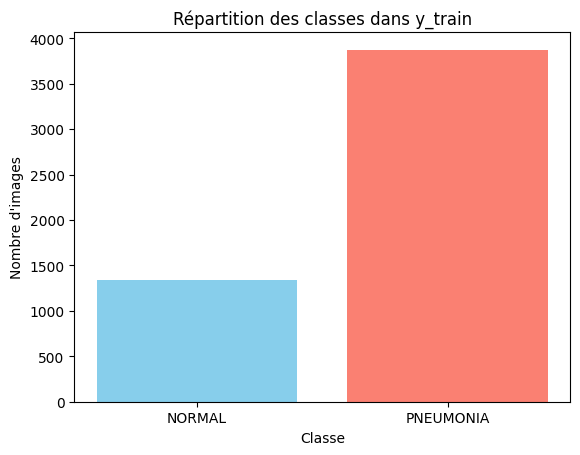

In [151]:
# Comptage des classes
classes, counts = np.unique(y_train, return_counts=True)

# Affichage en barres
plt.bar(classes, counts, color=["skyblue", "salmon"])
plt.xticks([0, 1], ["NORMAL", "PNEUMONIA"])
plt.title("Répartition des classes dans y_train")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()


In [152]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

## 🔍 5.2. Choix du modèle

Dans ce projet, nous avons choisi d'explorer deux approches de modélisation afin de comparer leurs performances :

### 1. Modèle CNN simple (construit manuellement): 

Nous avons d'abord conçu un réseau de neurones convolutionnel (CNN) simple avec Keras, composé de 3 à 4 couches convolutionnelles.

✅ Cette approche est pédagogique, intuitive, et permet de mieux comprendre les mécanismes d'apprentissage des réseaux de neurones appliqués à des images médicales.

### 2. Transfer learning (modèle pré-entraîné): 

Nous avons ensuite utilisé un modèle pré-entraîné (par exemple MobileNetV2 ou ResNet50) via la technique du transfer learning.

✅ Ce type de modèle a été préalablement entraîné sur une grande base de données (ImageNet), et permet de réutiliser des représentations déjà efficaces pour notre tâche.



🎯 Objectif de la double approche : 

Permettre d’améliorer la précision du modèle, en particulier lorsque le jeu de données est limité.
La double expérimentation permet d'observer les différences de performance, de vitesse d'apprentissage, et de généralisation entre un modèle entraîné de zéro et un modèle transféré.

In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # sortie binaire
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/Users/aminaabdm/Desktop/Brief_CNN_Transfer_Learning/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,827,905 (18.42 MB)

 Trainable params: 4,827,905 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️‍♂️ 5.3. Entrainement du modéle 

In [154]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights)

2025/05/28 17:16:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5f25e7a81ae84cd6970c7cb850636df6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6330 - loss: 0.5555

163/163 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.6339 - loss: 0.5545 - val_accuracy: 0.8253 - val_loss: 0.3729
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9464 - loss: 0.1397 - val_accuracy: 0.7147 - val_loss: 1.1694
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9607 - loss: 0.1134 - val_accuracy: 0.7708 - val_loss: 0.8039
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 151s 923ms/step - accuracy: 0.9615 - loss: 0.0972 - val_accuracy: 0.8221 - val_loss: 0.5813
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 761s 5s/step - accuracy: 0.9618 - loss: 0.0934 - val_accuracy: 0.8093 - val_loss: 0.6269
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


# 6. 📊 Évaluation du modèle CNN
_____

## 🏆 6.1. Scores : précision, rappel, F1-score, accuracy

In [155]:
from sklearn.metrics import classification_report, f1_score

# Prédictions sur les données de test
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype("int32")

# Rapport de classification complet
print("📊 Rapport de classification CNN :\n")
print(classification_report(y_test, y_pred_labels, target_names=["NORMAL", "PNEUMONIA"]))

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step
📊 Rapport de classification CNN :

              precision    recall  f1-score   support

      NORMAL       0.93      0.53      0.68       234
   PNEUMONIA       0.78      0.97      0.86       390

    accuracy                           0.81       624
   macro avg       0.85      0.75      0.77       624
weighted avg       0.83      0.81      0.79       624



🧠 Interprétation globale :

Bonne performance globale si F1-score élevé (>0.80), surtout pour la classe PNEUMONIA.

Observation d'un déséquilibre :

Si la précision est élevée mais le rappel faible (ou inversement), le modèle est biaisé.

Le modéle est très bon pour détecter PNEUMONIA, mais rate souvent les cas NORMAL → surdiagnostic.

## 📈  6.2. Courbe de perte et d’accuracy CNN

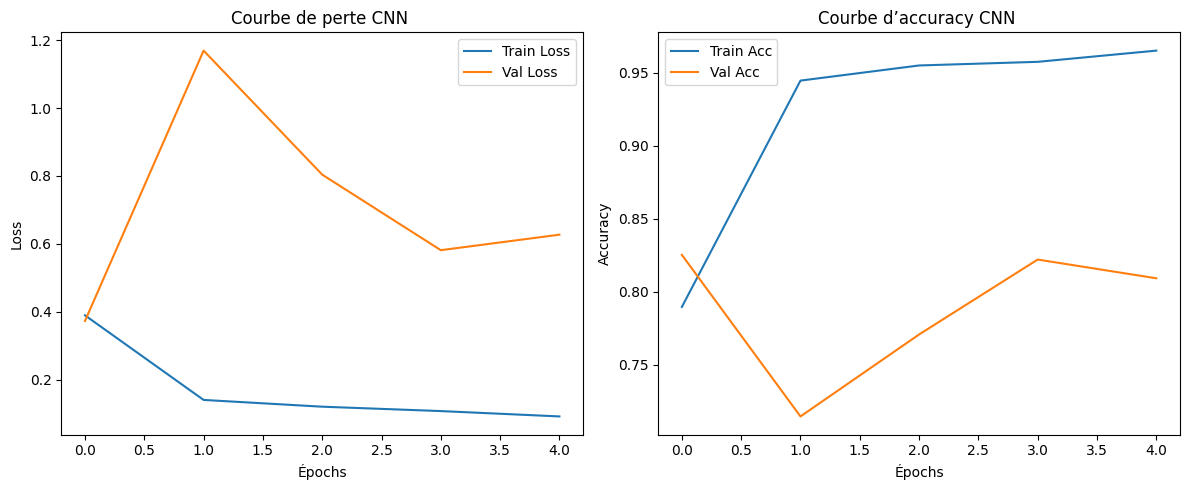

In [156]:
# Visualisation des courbes de perte et d'accuracy
# --- Courbe de perte
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Courbe de perte CNN ")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.legend()

# --- Courbe d’accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Courbe d’accuracy CNN ")
plt.xlabel("Épochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



##  🔢 6.3. Matrice de confusion 


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step


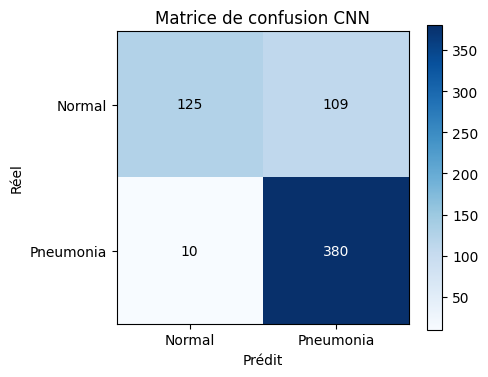

In [157]:
from sklearn.metrics import confusion_matrix

# 1. Prédictions binaires
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# 2. Générer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# 3. Affichage avec matplotlib
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de confusion CNN")
plt.colorbar()

classes = ["Normal", "Pneumonia"]
tick_marks = range(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# 4. Afficher les valeurs dans la matrice
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color="white" if cm[i, j] > cm.max()/2. else "black")

plt.ylabel("Réel")
plt.xlabel("Prédit")
plt.tight_layout()
plt.show()


### 🧠 Analyse :
- Le modèle détecte très bien les PNEUMONIA (rappel élevé), ce qui est médicalement très important ✅

- En revanche, il a tendance à trop prédire PNEUMONIA, d'où les 130 faux positifs (normal détecté à tort comme malade).

### 💡 Interprétation :

- Le modèle a une excellente capacité à détecter les cas de pneumonie (très peu de faux négatifs), ce qui est crucial dans un contexte médical.

- En revanche, il a tendance à sur-diagnostiquer la pneumonie, en classant certaines images normales comme malades (faux positifs élevés). Cela peut être dû au déséquilibre du jeu de données ou à un modèle encore perfectible.

# 7. 💾 Sauvegarde du modéle CNN
____


In [158]:
model.save("models/cnn_pneumonia.h5")  

# 8. 🎯 Transfer Learning 
____

## 🤖 8.1. Modéle VGG16 
___

⚙️ Pourquoi le Transfer Learning ?

Un modèle comme VGG16 a déjà appris à détecter des formes, textures et motifs génériques. On peut :

- Réutiliser ses couches convolutionnelles (features),

- Ajouter nos propres couches de classification (dense),

- Et l’adapter à notre dataset avec moins d’apprentissage.

### 🔹 Étape 1 : Importer les modules nécessaires : 

📌 Objectif : Importer le modèle pré-entraîné VGG16 et les outils nécessaires pour construire notre modèle personnalisé.

In [159]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam

### 🔹 Étape 2 : Charger le modèle VGG16 sans sa "tête" (couche de sortie)

In [161]:
import sys
!{sys.executable} -m pip install tables 

base_model = VGG16(weights='models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False,
                   input_shape=(150, 150, 3))

📌 Explication :

- weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5' : on récupère les poids appris sur le dataset.

- include_top=False : on ne garde pas les couches de classification d’origine.

- input_shape=(150, 150, 3) : on définit la taille de nos images (en RGB).

### 🔹 Étape 3 : Geler les couches de VGG16

In [162]:
for layer in base_model.layers:
    layer.trainable = False

### 📌 Pourquoi ?
On ne veut pas réentraîner les poids de VGG16. On utilise les features déjà apprises.

### 🔹 Étape 4 : Ajouter nos propres couches de classification

In [163]:
x = base_model.output
x = Flatten()(x)                      # Transformer en vecteur
x = Dense(128, activation='relu')(x)  # Couche dense personnalisée
x = Dropout(0.5)(x)                   # Dropout pour éviter le surapprentissage
output = Dense(1, activation='sigmoid')(x)  # Sortie binaire (malade / sain)


### 🔹 Étape 5 : Définir le modèle complet

In [164]:
model_tl = Model(inputs=base_model.input, outputs=output)

📌 On fusionne la partie "convolutive" (VGG16) avec notre tête personnalisée.

### 🔹 Étape 6 : Compiler le modèle

In [165]:
model_tl.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])


📌 On choisit :

- Un optimiseur (Adam),

- Une fonction de perte pour classification binaire,

- Une métrique d'évaluation (accuracy).

### 🔹 Étape 7 : Résumé du modèle

📌 Permet de visualiser l'architecture du modèle et les paramètres à entraîner.

In [166]:
model_tl.summary()


Model: "functional_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,521 (60.13 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 🔹 Étape 8 : Conversion des images en RGB

📌 Les modèles pré-entraînés attendent des images avec 3 canaux (RGB).
Si tes images étaient en niveaux de gris (1 canal), on les duplique sur 3 canaux.

In [167]:
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

### 🔹 Étape 9 : Entraîner le modèle

📌 On entraîne uniquement les dernières couches (notre tête personnalisée).

In [168]:
history = model_tl.fit(X_train_rgb, y_train,
                       epochs=3,
                       batch_size=32,
                       validation_data=(X_test_rgb, y_test),
                       class_weight=class_weights) 


2025/05/28 17:43:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '87496006333f47f4a517dd0021d7a42b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8153 - loss: 0.4032

163/163 ━━━━━━━━━━━━━━━━━━━━ 1025s 6s/step - accuracy: 0.8158 - loss: 0.4025 - val_accuracy: 0.8109 - val_loss: 0.4059
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9532 - loss: 0.1479

163/163 ━━━━━━━━━━━━━━━━━━━━ 1009s 6s/step - accuracy: 0.9531 - loss: 0.1478 - val_accuracy: 0.8542 - val_loss: 0.3556
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 1055s 6s/step - accuracy: 0.9558 - loss: 0.1182 - val_accuracy: 0.8157 - val_loss: 0.4540
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


## 📈  8.1.1. Courbe de perte et d’accuracy VGG16

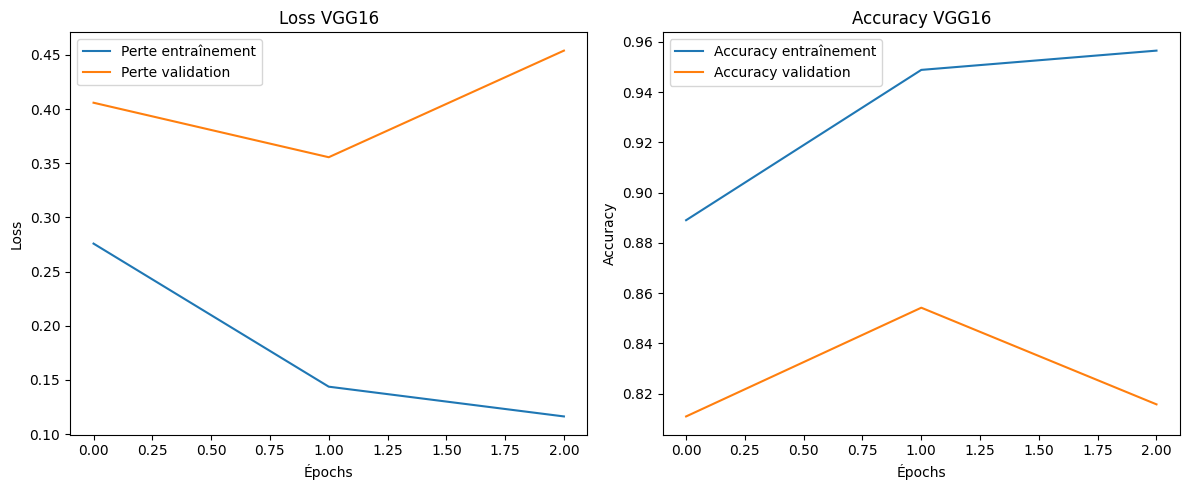

In [169]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title("Loss VGG16")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.legend()

# Courbes d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy entraînement')
plt.plot(history.history['val_accuracy'], label='Accuracy validation')
plt.title("Accuracy VGG16")
plt.xlabel("Épochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## 🔢 8.1.2. Matrice de confusion du modéle VGG16

20/20 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step


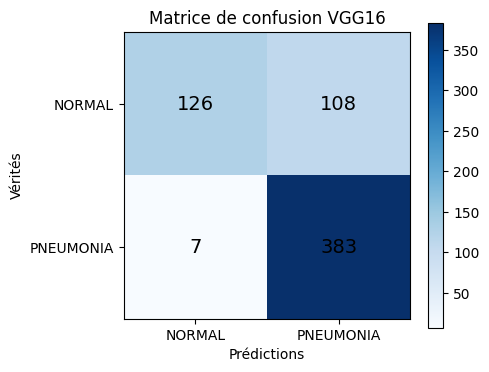

In [170]:
# Prédictions sur le jeu de test
y_pred_probs = model_tl.predict(X_test_rgb)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Seulement 0 ou 1

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage avec Matplotlib
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title("Matrice de confusion VGG16")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")

# Affichage des valeurs dans chaque case
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=14)

plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.yticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.colorbar()
plt.tight_layout()
plt.show()

## 🏆 8.1.3. Scores : précision, rappel, F1-score, accuracy VGG16


In [171]:
from sklearn.metrics import classification_report, accuracy_score

# Rapport détaillé
print("📊 Rapport de classification VGG16 :\n")
print(classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy globale : {acc:.2f}")

📊 Rapport de classification VGG16 :

              precision    recall  f1-score   support

      NORMAL       0.95      0.54      0.69       234
   PNEUMONIA       0.78      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.76      0.78       624
weighted avg       0.84      0.82      0.80       624

✅ Accuracy globale : 0.82


🎯 Interpretation des résultats obtenus :

✅ Bonne précision pour NORMAL (0.95) : quand le modèle prédit "NORMAL", il a souvent raison.

⚠️ Mauvais rappel pour NORMAL (0.58) : il manque beaucoup de cas "NORMAL", en les classant comme "PNEUMONIA".

✅ Excellent rappel pour PNEUMONIA (0.98) : presque tous les cas de pneumonie sont détectés.

⚖️ Accuracy globale : 82%, mais déséquilibre dans les performances par classe.

📌 Conclusion :

Le modèle est très bon pour détecter la pneumonie, mais il a du mal à reconnaître les cas normaux. 

Cela peut être :

- lié à un déséquilibre de classes (beaucoup plus de cas "PNEUMONIA"),

- ou à un biais dans les images ou le prétraitement.



##  💾 8.1.4. Sauvegarde du modéle Transfer Learning 

In [172]:
model.save("models/transfer_learning_VGG16.keras")

# 9. 🔬 Suivi des expériences avec MLflow
___

🎯 Objectif de MLflow :

- Suivre les entraînements (accuracy, loss, etc.)

- Sauvegarder les modèles avec leurs hyperparamètres

- Comparer plusieurs versions (CNN, Transfer Learning…)

- Reproduire facilement une expérience

## 🤖 9.1. MLflow pour Transfer Learning (Keras + VGG16)

In [173]:
import mlflow
mlflow.set_tracking_uri("file:/Users/aminaabdm/Desktop/Brief_CNN_Transfer_Learning/mlruns")

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

mlflow.tensorflow.autolog()

# with mlflow.start_run():
    # model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, class_weight=class_weights)
    # model = tf.keras.models.load_model("models/transfer_learning_VGG16.keras")
   


In [174]:
print(model.input_shape)

(None, 150, 150, 1)


In [175]:
import mlflow
import mlflow.tensorflow
import tensorflow as tf

# Configuration de MLflow
if mlflow.active_run() is not None:
    mlflow.end_run()
    
# Activation du suivi automatique,
mlflow.tensorflow.autolog()

# Démarrage d'une expérience MLflow,
with mlflow.start_run(): # Tous les paramètres ci-dessous sont traqué par MLflow
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5
    )
    
    

2025-05-28 18:39:11.842393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-28 18:39:12.156301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9777 - loss: 0.0686

163/163 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9777 - loss: 0.0687 - val_accuracy: 0.7340 - val_loss: 1.0988
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.9795 - loss: 0.0587 - val_accuracy: 0.7484 - val_loss: 1.1677
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9803 - loss: 0.0592 - val_accuracy: 0.7356 - val_loss: 1.1635
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.9761 - loss: 0.0658 - val_accuracy: 0.7692 - val_loss: 1.1074
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.9841 - loss: 0.0443 - val_accuracy: 0.7724 - val_loss: 1.2515


2025-05-28 18:58:45.584130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


In [176]:
# Pour visualiser les résultats, ouvrez un terminal et exécutez la commande suivante :
# mlflow ui
# Ensuite, ouvrez votre navigateur à l'adresse http://localhost:5001 pour voir les résultats de l'expérience.


## 9.2. 💾 Sauvegarde du modéle MLflow VGG16

In [180]:
# Sauvegarde du modèle
mlflow.tensorflow.log_model(model, "mlflow_vgg16_model")


2025/05/28 19:08:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/28 19:09:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
